# Mann-Whitney U-test for translational prioritization

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import seaborn as sns
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

### Load annotation

In [2]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0)

### Simplify subsystems

In [3]:
def simplify(s):
    if isinstance(s,float):
        return s
    s = s.split("__")[-1]
    s = s.replace("S_","")
    s = s.replace("_"," ")
    s = s.replace("Metabolic:","")
    return s

In [4]:
Annotation["subsystem"] = Annotation["subsystem"].apply(lambda x:simplify(x))

### Load data

In [5]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [6]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

### Group data by subsystem

In [7]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
all_samples = samples+rna_samples
colors = ["#2b83ba","#66bd63","#fdae61"]

In [8]:
Results = ribo.join(rna,rsuffix="_rna")
Results = Results.div(Results.sum())*1e6 # CPM
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]

In [9]:
ResultsGrouped = ResultsAnnotated[all_samples+["subsystem"]].groupby("subsystem").sum()

### Prepare data for MW test

In [10]:
tmp = ResultsAnnotated[rna_samples]
tmp.columns = samples
StackedResults = pandas.concat([
    ResultsAnnotated[samples].stack().to_frame().rename(columns={0:"ribo"}),
    tmp.stack().to_frame().rename(columns={0:"rna"})],axis=1)
StackedResults["locus"] = StackedResults.index.get_level_values(0)
StackedResults["subsystem"] = StackedResults["locus"].apply(lambda x:Annotation.loc[x]["subsystem"])
StackedResults.index = StackedResults.index.map('{0[0]}_{0[1]}'.format)
StackedResults = StackedResults.dropna() # Get rid of datapoints with no subsystem annotation

### Get ranks

In [11]:
rank = pandas.DataFrame()
for col in ["rna","ribo"]:
    tmp = StackedResults[col].sort_values()
    rank[col] = tmp.rank().astype(int)
rank = rank.fillna(rank.shape[0])
# rank = (rank.shape[0] + 1 - rank)

In [12]:
RankAnnotated = pandas.concat([rank,StackedResults["subsystem"]],axis=1)

### Mann Whitney overrepresentation

In [13]:
from scipy.stats import mannwhitneyu

In [14]:
dct = {}
for subsystem in RankAnnotated["subsystem"].dropna().unique():
    slice = RankAnnotated[RankAnnotated["subsystem"] == subsystem]
    res = mannwhitneyu(slice["ribo"],slice["rna"], alternative="greater")
    dct[subsystem] = {
        "fold" : ResultsGrouped.loc[subsystem][samples].mean()/ResultsGrouped.loc[subsystem][rna_samples].mean(),
        "stat" : res.statistic,
        "pval" : res.pvalue,
        "n" : len(slice)
    }
MW_greater = pandas.DataFrame.from_dict(dct).T
# MW_greater.index = MW_greater.reset_index()["index"].apply(lambda x:simplify(x))

In [15]:
MW_greater.sort_values("fold",ascending=False)

,fold,stat,pval,n
Ribose Metabolism,4.520410,102.0,0.675898,15.0
Alternate Carbon,2.409528,242.0,0.298656,21.0
Nicotinamide Biosynthesis,2.090428,554.0,0.000538,27.0
Feclusters metabolism,2.033524,27.0,0.089827,6.0
Phenylalanine Tyrosine Tryptophan Biosynthesis,1.980119,2801.5,0.036677,69.0
...,...,...,...,...
Butanediol Metabolism,0.295735,75.0,0.942547,15.0
Formaldehyde Metabolism,0.290232,561.0,0.837802,36.0
Phenylacetyl CoA Catabolom,0.289094,482.5,0.969263,36.0
Levulinate Metabolism,0.154844,35.0,0.999392,15.0


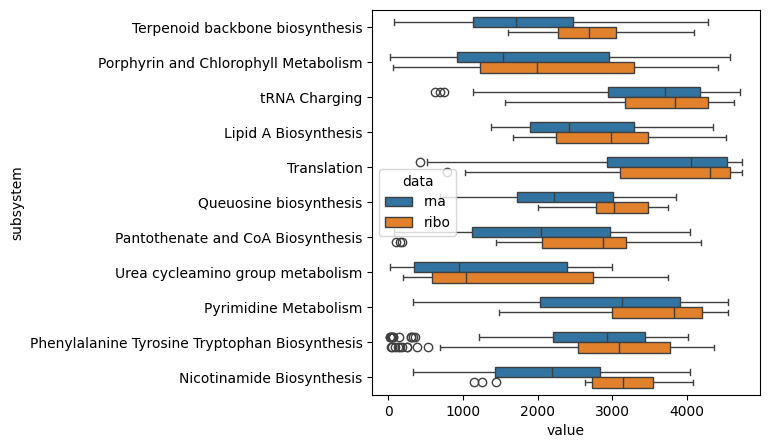

In [16]:
upreg = MW_greater[MW_greater["pval"]<0.05].sort_values("fold",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(5,5))
df = RankAnnotated[RankAnnotated["subsystem"].str.contains("|".join(upreg.index))]
dd = pandas.melt(df,id_vars=['subsystem'],value_vars=['rna','ribo'],var_name='data')
# order = dd.groupby("subsystem").mean().sort_values("value").index
order_up = upreg.sort_values("fold").index
bp = sns.boxplot(y='subsystem',x='value',data=dd,orient="h",hue='data',width=0.6,ax=ax,order=order_up)
fig.savefig("./figures/mw-test-upreg.svg",format="svg")

In [17]:
upreg

,fold,stat,pval,n
Nicotinamide Biosynthesis,2.090428,554.0,0.000538,27.0
Phenylalanine Tyrosine Tryptophan Biosynthesis,1.980119,2801.5,0.036677,69.0
Pyrimidine Metabolism,1.948817,2363.0,0.001577,60.0
Urea cycleamino group metabolism,1.776587,1246.5,0.029761,45.0
Pantothenate and CoA Biosynthesis,1.753812,968.5,0.019055,39.0
Queuosine biosynthesis,1.744958,321.0,0.005942,21.0
Translation,1.701104,33042.0,0.038755,246.0
Lipid A Biosynthesis,1.676681,964.0,0.021246,39.0
tRNA Charging,1.577691,9037.0,0.028801,126.0
Porphyrin and Chlorophyll Metabolism,1.382862,6506.0,0.012056,105.0


### Mann Whitney underrepresentation

In [18]:
dct = {}
for subsystem in RankAnnotated["subsystem"].dropna().unique():
    slice = RankAnnotated[RankAnnotated["subsystem"] == subsystem]
    res = mannwhitneyu(slice["ribo"],slice["rna"], alternative="less")
    dct[subsystem] = {
        "fold" : ResultsGrouped.loc[subsystem][samples].mean()/ResultsGrouped.loc[subsystem][rna_samples].mean(),
        "stat" : res.statistic,
        "pval" : res.pvalue,
        "n" : len(slice)
    }
MW_less = pandas.DataFrame.from_dict(dct).T

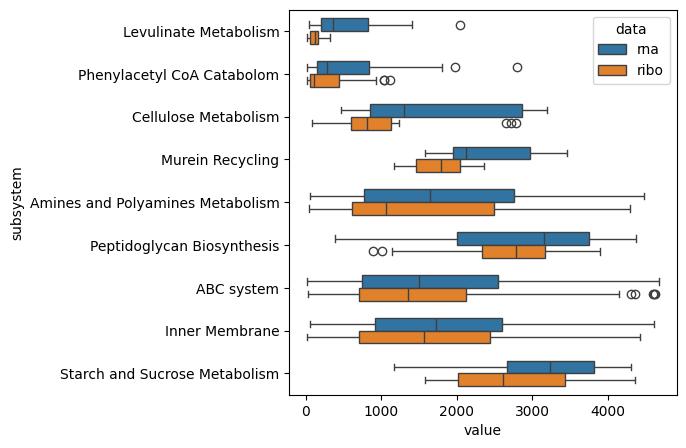

In [19]:
downreg = MW_less[MW_less["pval"]<0.05].sort_values("fold",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(5,5))
df = RankAnnotated[RankAnnotated["subsystem"].str.contains("|".join(downreg.index))]
dd = pandas.melt(df,id_vars=['subsystem'],value_vars=['rna','ribo'],var_name='data')
# order = dd.groupby("subsystem").mean().sort_values("value").index
order_down = downreg.sort_values("fold").index
bp = sns.boxplot(y='subsystem',x='value',data=dd,orient="h",hue='data',width=0.6,ax=ax,order=order_down)
fig.savefig("./figures/mw-test-downreg.svg",format="svg")

In [20]:
downreg

,fold,stat,pval,n
Starch and Sucrose Metabolism,0.962423,452.0,0.013841,36.0
Inner Membrane,0.961626,55206.0,0.021926,348.0
ABC system,0.818831,94623.0,0.044620,450.0
Peptidoglycan Biosynthesis,0.817621,2974.0,0.039557,84.0
Amines and Polyamines Metabolism,0.720354,6917.5,0.009636,129.0
Murein Recycling,0.506182,32.0,0.011259,12.0
Cellulose Metabolism,0.494853,63.0,0.021055,15.0
Phenylacetyl CoA Catabolom,0.289094,482.5,0.031528,36.0
Levulinate Metabolism,0.154844,35.0,0.000702,15.0


### TE

/tmp/ipykernel_347762/3909744978.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()
/home/jt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


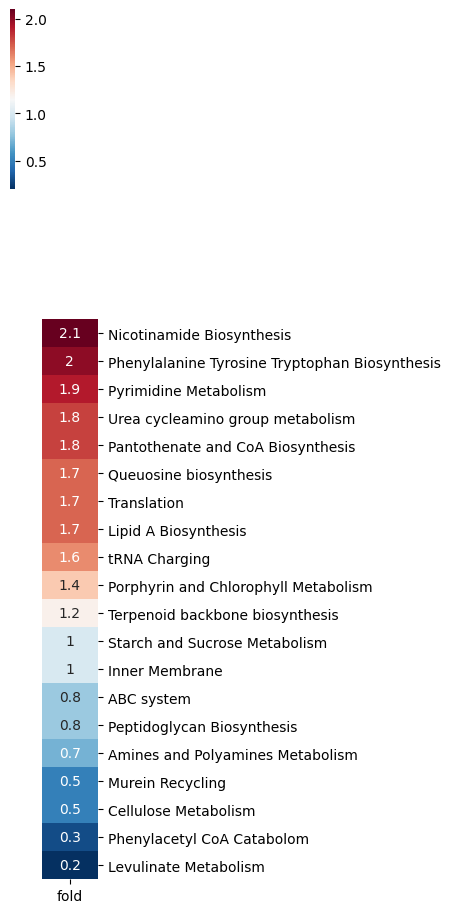

In [21]:
import seaborn as sns
cmap_df = pandas.concat([upreg,downreg])["fold"].round(1)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               # fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(1,10),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
plt.savefig("./figures/mw-te-colorbar.svg",format="svg")